In [1]:
%%capture
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install fiona
!pip install geopandas
!pip install PyCRS
!pip install -i https://test.pypi.org/simple/ gis-utils-pkg-dillhicks==0.0.3

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Orthomosaics/2018-07 La Paz/Site 5/lap_2018-07_site05_120m_RGB_cc.tif" .
!cp "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Orthomosaics/2018-07 La Paz/Site 5/lap_2018-07_site05_planetscope_optical.tif" . 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
from gis_utils import raster

planetscope = "lap_2018-07_site05_planetscope_optical.tif"
drone = "lap_2018-07_site05_120m_RGB_cc.tif"

d_img, d_meta = raster.load_image(drone)


In [5]:
!gdal_retile.py -ps 1 1 -targetDir tiles/  {planetscope}

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [31]:
!pip install PyCRS

  Created wheel for PyCRS: filename=PyCRS-1.0.2-cp36-none-any.whl size=32683 sha256=172cfa0c0c536437357c389549fc195dd271efa6670c56e0d46f4feed4a08a2e
  Stored in directory: /root/.cache/pip/wheels/1a/c9/56/648f762bd41fdb03454be51b8a7069795925168833cb61f316
Successfully built PyCRS


In [9]:
import rasterio
from shapely.geometry import box
import geopandas as gpd
from rasterio.mask import mask
from rasterio.plot import show
from tqdm.autonotebook import tqdm
import os
from rasterio import windows as wind
from fiona.crs import from_epsg
from gis_utils import raster

In [38]:
from os.path import join
import pycrs

d_img, meta = raster.load_image(drone)
out_meta = meta
d_bbox = box(d_img.bounds.left, d_img.bounds.bottom, d_img.bounds.right, d_img.bounds.top)


In [23]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [39]:
out_path = '/content/dronetiles/'
output_filename = 'drone_{}.tif'

for root, dirs, files in os.walk("/content/tiles"):
    for file in tqdm(files):
        name = os.path.splitext(file)[0]
        dataset, _ = raster.load_image(join(root,file))
        bounds = dataset.bounds
        bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
        if bbox.within(d_bbox):
            geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
            geo = geo.to_crs(crs=dataset.crs.data)
            coords = getFeatures(geo)
            out_img, out_transform = mask(d_img, shapes=coords, crop=True)
            out_meta.update({"driver": "GTiff","height": out_img.shape[1], "width": out_img.shape[2], "transform": out_transform, "crs": from_epsg(4326)})
            outpath = os.path.join(out_path,output_filename.format(name))
            with rasterio.open(outpath, 'w', **out_meta) as outds:
                outds.write(out_img)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [19]:
dataset.bounds

BoundingBox(left=-110.31295874694506, bottom=24.24930232807364, right=-110.31292920658963, top=24.249329414430125)

In [40]:
!gdal_merge.py -o /content/new.tif /content/dronetiles/*

0...10...20...30...40...50...60...70...80...90...100 - done.


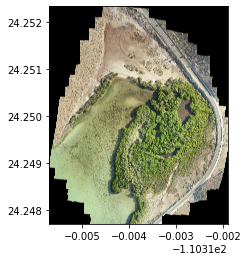

In [41]:
test, test_meta = raster.load_image("new.tif")
show(test)

In [ ]:
!zip -r tiles.zip dronetiles

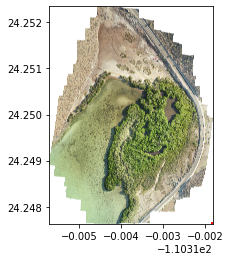

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1)

show(d_img, ax=ax)
geo.plot(ax=ax,facecolor='red', edgecolor='red')
